# EOF Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime
from dateutil.relativedelta import relativedelta
import time

from cartopy import crs as ccrs, feature as cfeature
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import glob, os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import xskillscore as xs

from eofs.xarray import Eof
from eofs.standard import Eof as sEof # If needed
from eofs.multivariate.standard import MultivariateEof

from scipy import stats
import statsmodels.api as sm

sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()
import matplotlib.patches as mpatches

%run utils.ipynb

# 1. Load in the model datasets

## We want to load in the smoothed anomaly timeseries.

In [2]:
# LOAD SIC: 1x0.5
filename = 'gs://leap-persistent/dhruvbalwada/SI_pred_project/sic_1X0p5.zarr'
sic_anom_ds = xr.open_zarr(filename)
sic_anom = sic_anom_ds.sic_anom_smoothed

# LOAD 6 (for now) other model variables: 2x2
filename = 'gs://leap-persistent/dhruvbalwada/SI_pred_project/vars_2x2.zarr'
vars_2x2 = xr.open_zarr(filename)
sst_anom = vars_2x2.sst_anom_smoothed    # 1
sat_anom = vars_2x2.sat_anom_smoothed    # 2
z_anom = vars_2x2.z_anom_smoothed        # 3
u_anom = vars_2x2.u_anom_smoothed        # 4
v_anom = vars_2x2.v_anom_smoothed        # 5
sthf_anom = vars_2x2.sthf_anom_smoothed  # 6

# File naming conventions, selecting # of vars:
var_names = ['sic', 'sst', 'sat', 'z', 'u', 'v', 'sthf']

#___ CHANGE the scaling here!
var_scaling = [2, 1, 1, 0.5, 0.5, 0.5, 1]
#var_scaling = [2, 1, 1, 1, 1, 1, 1]
#var_scaling = [2, 1, 1, 0.5, 0.5, 0.5, 0.5]

# GOAL: Get new stds's, then normalize anomalies, so now all of the anomaly std's are = 1. on same scale.

# Calculate new std's, save new stds into one array.
sic_std = sic_anom.std() / var_scaling[0]
sst_std = sst_anom.std() / var_scaling[1]
sat_std = sat_anom.std() / var_scaling[2]
z_std = z_anom.std() / var_scaling[3]
u_std = u_anom.std() / var_scaling[4]
v_std = v_anom.std() / var_scaling[5]
sthf_std = sthf_anom.std() / var_scaling[6]
stds = [sic_std, sst_std, sat_std, z_std, u_std, v_std, sthf_std]

# Normalize the anomalies, save normalized anomalies into one array
norm_sic_anom = sic_anom/sic_std
norm_sst_anom = sst_anom/sst_std
norm_sat_anom = sat_anom/sat_std
norm_z_anom = z_anom/z_std
norm_u_anom = u_anom/u_std
norm_v_anom = v_anom/v_std
norm_sthf_anom = sthf_anom/sthf_std

# Convert normalized anomalies to numpy normalizes anomalies.
np_sic_anom = norm_sic_anom.to_numpy()
np_sst_anom = norm_sst_anom.to_numpy()
np_sat_anom = norm_sat_anom.to_numpy()
np_z_anom = norm_z_anom.to_numpy()
np_u_anom = norm_u_anom.to_numpy()
np_v_anom = norm_v_anom.to_numpy()
np_sthf_anom = norm_sthf_anom.to_numpy()
np_vars = [np_sic_anom, np_sst_anom, np_sat_anom, np_z_anom, np_u_anom, np_v_anom, np_sthf_anom]

# Latitude weight creation
sic_wgts = np.cos(np.deg2rad(sic_anom_ds.coords['y'].values)).clip(0., 1.)[..., np.newaxis]
#     sic_wgts = np.cos(np.deg2rad(sic_anom_ds.y.data))[:, np.newaxis] also works.
vars_wgts = np.cos(np.deg2rad(vars_2x2.coords['y'].values)).clip(0., 1.)[..., np.newaxis]

# 2. Choose the # of variables and # of modes, to run the hindcast + cross validation markov model creation.

### define the setup_model function below

In [3]:
def setup_model(indices):
    model_vars = [np_vars[x] for x in indices]
    f_start = '_'.join([var_names[x] for x in indices])
    f_scal = '*'.join([str(var_scaling[x]) for x in indices])
    f_name = f_start + '-' + f_scal
    model_wgts = [sic_wgts]
    for x in range(len(indices)-1):
        model_wgts.append(vars_wgts)
    return model_vars, model_wgts, f_name

### HERE: Change the indices, corresponding to the variables you want to include in the model.

In [4]:
# reminder: var_names = ['sic', 'sst', 'sat', 'z', 'u', 'v', 'sthf']
indices = [0, 1, 2, 3, 4, 5, 6] # our best one we think: 0, 1, 2, 6
#indices = [0, 1, 2]
model_vars, model_wgts, f_name = setup_model(indices)
nv = len(indices)
print(f_name)

sic_sst_sat_z_u_v_sthf-2*1*1*0.5*0.5*0.5*1


### Run the MEOF solver

In [5]:
# We think modes 9-12 are pretty good. Stick w 9 maybe, for final model.
for modes in range(9,10):
    # Give the output a full file name in the format:
    # variables_separated_by_underscores - weights*separated*by*astericks - #ofmodes
    complete_fname = f_name+'-'+ str(modes) + '.nc'
    print('Building hcast and cross for: '+ complete_fname)
    
    # run the solver here.
    solver = MultivariateEof(model_vars,
                         weights = model_wgts, center=False)
    nvars = nv-1 # nvars: number of variables NOT sic. ex. sst, sat: nvars = 2. i=0, 1.
    
    #____________________Solve for MEOFs, PCs
    # define the lat, lon coordinates for the variables.
    sic_lat_bins = np.arange(-89.5, -49.5, 0.5)
    sic_lon_bins = np.arange(0., 360, 1)
    vars_lat_bins = np.arange(-88., -49, 2)
    vars_lon_bins = np.arange(0., 359, 2)

    # get the eofs, pcs, eigenvalues here.
    np_eofs_list = solver.eofs(neofs=modes) # scale by something here?
    np_eofscov_list = solver.eofsAsCovariance(neofs=modes)
    np_pcs = solver.pcs(npcs=modes)
    np_eigs = solver.eigenvalues(neigs=modes) 
    sum_eigs = solver.eigenvalues().sum()
    percent_var = np_eigs.sum() / solver.eigenvalues().sum()
    tav = solver.totalAnomalyVariance()
    vf = solver.varianceFraction()

    # turn the list of eofs for each variable used in the model into SIC_EOFs, and the rest of the eofs.
    sic_eofs = xr.DataArray(np_eofs_list[0],
                           coords = [np.arange(0, modes), sic_lat_bins, sic_lon_bins],
                            dims=['mode', 'y', 'x']) * stds[0]
    all_vars_eofs = [sic_eofs] # all_vars_eofs is eventually what has all the eofs to be plotted.
    for i in range(nvars):
        all_vars_eofs.append(xr.DataArray(np_eofs_list[i + 1],
                           coords = [np.arange(0, modes), vars_lat_bins, vars_lon_bins],
                            dims=['mode', 'y', 'x']) * stds[i + 1])
        
    # for each mode, get the pc timeseries for all the eofs.
    pcs = xr.DataArray(np_pcs, coords=[sic_anom.tdim, np.arange(0, modes)],
                      dims=['tdim', 'mode'])
    
    # Collapse sic_eofs and other eofs from 2d into 1d.
    stacked_sic_eofs = sic_eofs.stack(n=("y","x"))#28800 grid points
    all_stacked_eofs = [stacked_sic_eofs] # all_stacked_eofs is eventually all the stacked eofs.
    for i in range(nvars):
        all_stacked_eofs.append(all_vars_eofs[i+1].stack(n=("y", "x"))) #append a multiple of 3600 grid points
    meofs_2d = xr.concat(all_stacked_eofs, "n") 
  

Building hcast and cross for: sic_sst_sat_z_u_v_sthf-2*1*1*0.5*0.5*0.5*1-9.nc


### Show the first five modes, and the first [modes] pcs

[2447.23827215 1695.20557032 1324.41992367 1052.46547407  899.95553571
  766.07745869  713.38475772  581.83608964  557.58774157]


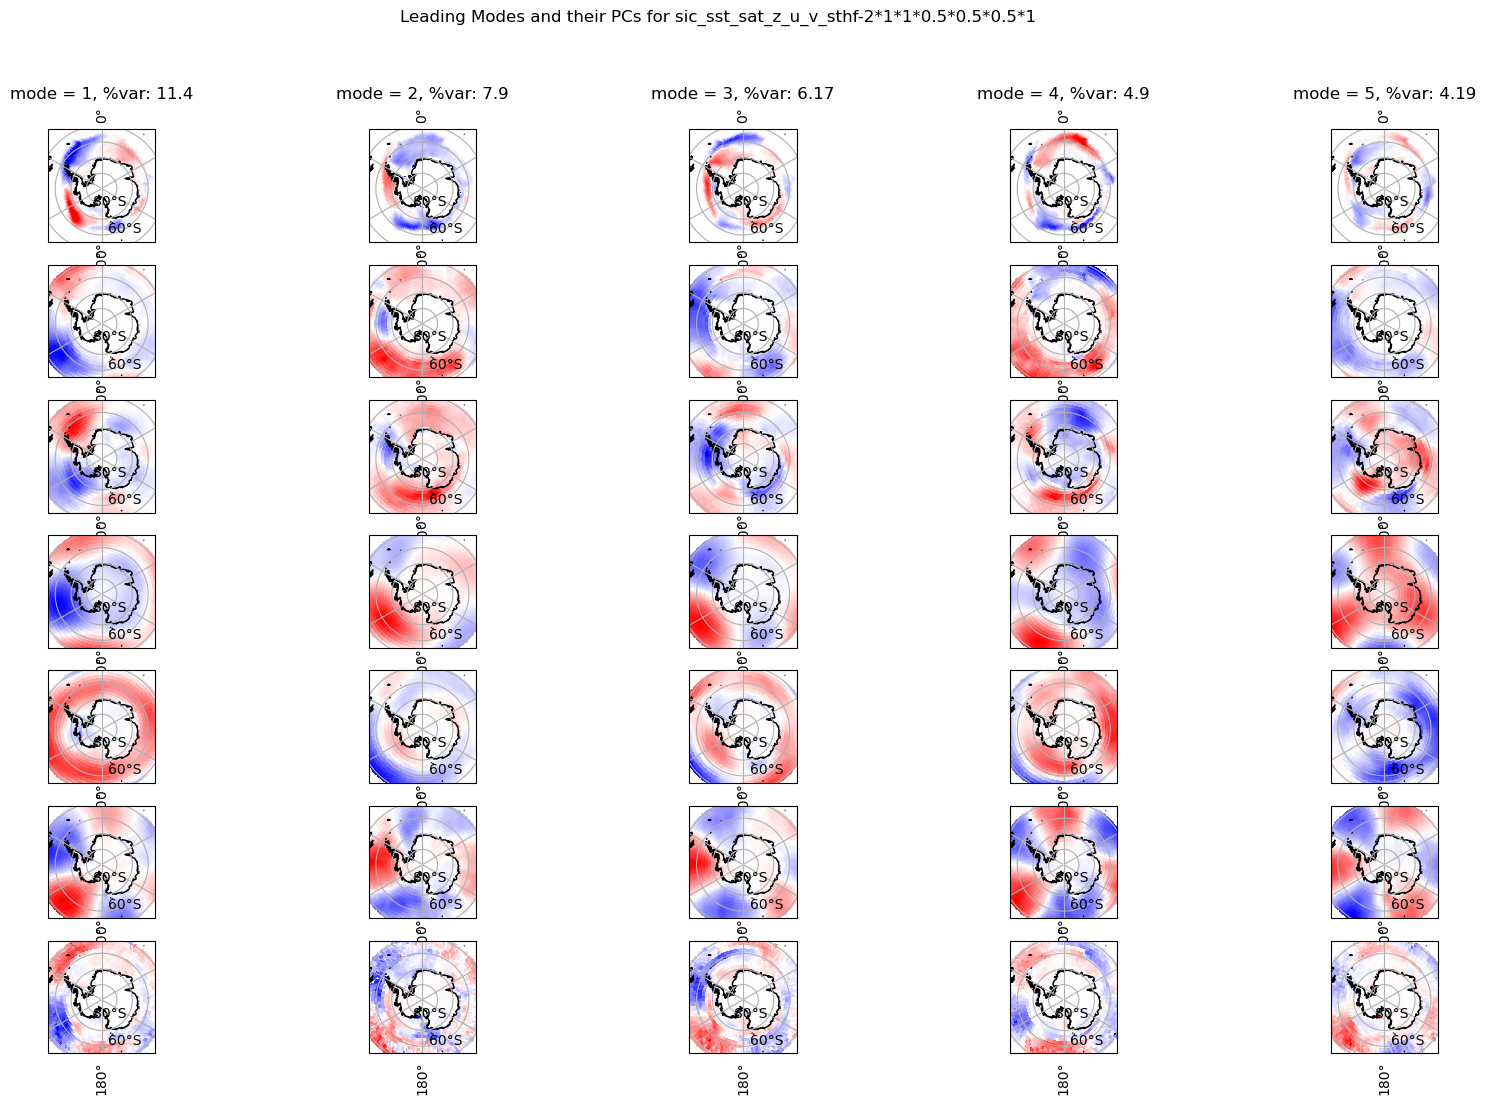

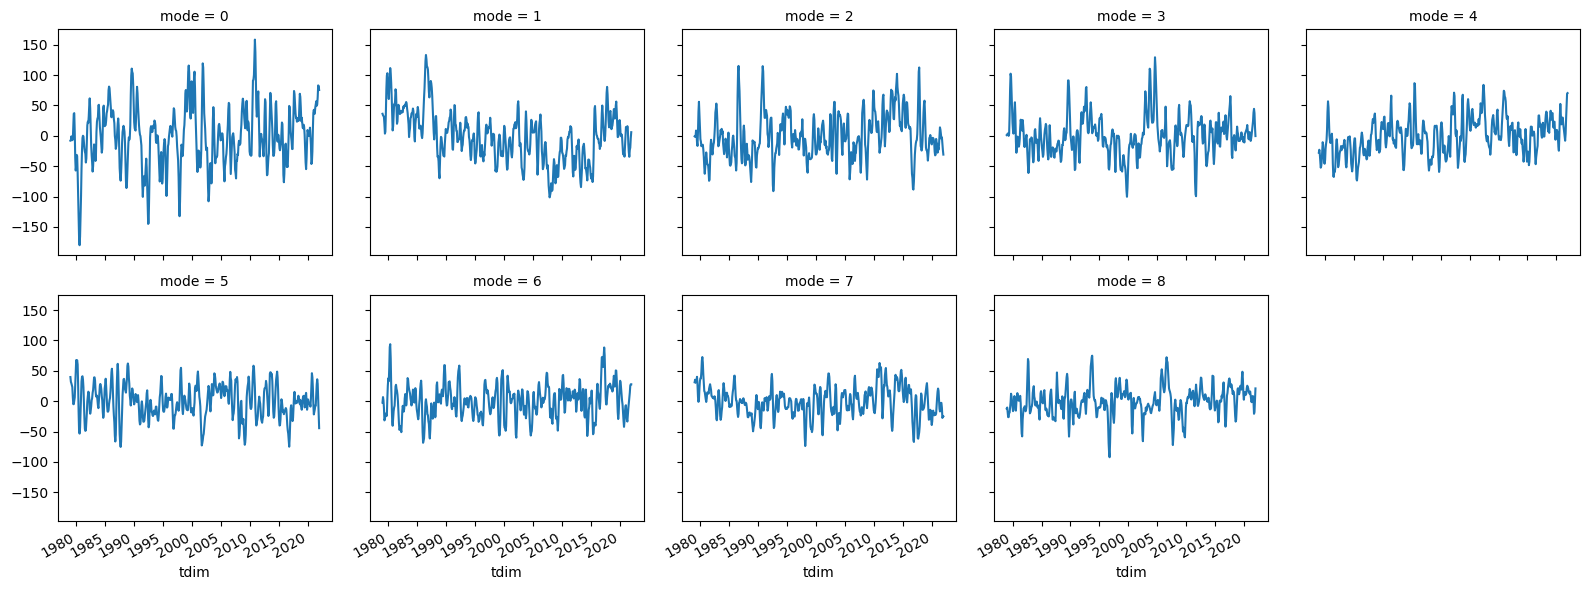

In [6]:
fig = plt.figure(figsize=(20,12))
for mode in range(min(5,modes)):
    # SIC EOFs
    ax = plt.subplot(len(indices), 5, mode + 1, projection=sp)
    # take the maximum real value it represents. (vmin = -.3, vmax = .3 is arbitrary. helps tho.)
    sic_mode = sic_eofs[mode]*pcs.sel(mode=mode).max()*var_scaling[0]
    im = sic_mode.plot(transform=pc, vmin=-.3, vmax=.3, cmap = 'bwr', add_colorbar=False)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('mode = ' + str(mode+1) + ', %var: ' + str(round(np_eigs[mode]/sum_eigs * 100, 2)))

    
    #OTHER VAR EOFS: all_vars_eofs[i+1] for i in range(nvars)
    for i in range(nvars):
        ax = plt.subplot(len(indices), 5, mode + 1 + 5*(i+1), projection=sp)
        vars_mode = all_vars_eofs[i + 1][mode]*pcs.sel(mode=mode).max()*var_scaling[indices[i]]
        im = vars_mode.plot(transform=pc, cmap = 'bwr', add_colorbar=False)
        
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
        ax.set_title('')
plt.suptitle('Leading Modes and their PCs for ' + f_name)

# Plot corresponding PCs
if modes > 1:
    pcs.plot(x='tdim',col='mode',col_wrap=min(5, modes));
print(solver.eigenvalues(neigs=modes))

### Data conversion into Pandas Dataframe for easier manipulation

In [7]:
ds = pcs.isel(mode=1)

df = ds.to_dataframe('pc')

df = df.drop('mode', axis=1)

df

,pc
tdim,
1979-01-01,36.308796
1979-02-01,33.796405
1979-03-01,32.699738
1979-04-01,31.010540
1979-05-01,19.542715
...,...
2021-08-01,-34.544995
2021-09-01,-23.154314
2021-10-01,-19.436222


In [8]:
df.reset_index(drop=False, inplace=True)

### Normalization / Splitting of Data

In [12]:
from sklearn.preprocessing import StandardScaler

scalers = {}
for x in df.columns:
  scalers[x] = StandardScaler().fit(df[x].values.reshape(-1, 1))

norm_df = df.copy()
for i, key in enumerate(scalers.keys()):
  norm = scalers[key].transform(norm_df.iloc[:, i].values.reshape(-1, 1))
  norm_df.iloc[:, i] = norm

norm_df

,tdim,pc
0,-1.728567,0.878295
1,-1.721730,0.817214
2,-1.715554,0.790553
3,-1.708717,0.749486
4,-1.702100,0.470684
...,...,...
511,1.701842,-0.844277
512,1.708679,-0.567351
513,1.715296,-0.476958
514,1.722134,-0.097253


# My first attempt at making input output pairs (This is shit)

In [10]:
# Insert empty columns to the left of the last column
#norm_df.insert(loc=1, column='pc(t-2)', value=None)
#norm_df.insert(loc=2, column='pc(t-1)', value=None)
#norm_df.rename(columns={'pc': 'pc(t)'}, inplace=True)

#norm_df['pc(t-2)'] = norm_df['pc(t)'].iloc[0:514]
#norm_df['pc(t-1)'] = norm_df['pc(t)'].iloc[1:515]
#norm_df['pc(t)'] = norm_df['pc(t)'].iloc[2:516]

#X = norm_df.iloc[:, :3]  # Select the first three columns
#y = norm_df.iloc[:, -1:]  # Select the last column

#X['pc(t-1)'] = X['pc(t-1)'].shift(-1)
#X = X.iloc[:-2]

#y['pc(t)'] = y['pc(t)'].shift(-2)
#y = y.iloc[:-2]

### Example by Dhruv

In [13]:
#Xnew = norm_df[0:514]
#Ynew = norm_df[1:515].pc

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(Xnew, Ynew, test_size=0.2, shuffle=False)


### Splitting data into input-output pairs using sliding window algorithm

In [170]:
def df_to_X_y(df, windowsize):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - windowsize):
        # Create the input sequence with the corresponding 'pc' values
        input_sequence = [[df_as_np[i+windowsize, 0]]]  # 'tdim' value at the fifth position
        input_sequence.extend([[a] for a in df_as_np[i:i+windowsize, 1]])  # 'pc' values
        X.append(input_sequence)

        # Add the corresponding output value
        output_value = df_as_np[i+windowsize, 1]  # 'pc' value at the next time step
        y.append(output_value)

    return np.array(X), np.array(y)

In [20]:
#def df_to_X_y(df, windowsize):
    #df_as_np = df.to_numpy()
    #X = []
    #y = []
    #for i in range(len(df_as_np) - windowsize):
        #row = [[a] for a in df_as_np[i:i+windowsize]]
        #X.append(row)
        #label = df_as_np[i+windowsize]
        #y.append(label)
    #return np.array(X), np.array(y)

In [171]:
window_val = 4
X,y = df_to_X_y(norm_df, window_val)

In [172]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Model 1, Vanilla Neural Network

In [342]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout
from keras.layers import Dense
from utils import * 

In [343]:
# set hyperparameters
n_neuron       = 32
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 128

In [345]:
model_1 = Sequential()

dropout_rate = 0.2

model_1.add(Dense(n_neuron,  activation='relu', name="hidden_layer_1" ,input_shape=(5,)))

model_1.add(Dense(n_neuron,  activation='relu', name="hidden_layer_2"))

model_1.add(Dense(1,  activation='linear', name="output_layer"))


model_1.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [346]:
model_1.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 32)                192       
                                                                 
 hidden_layer_2 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [347]:
history = model_1.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = None )

Epoch 1/50
3/3 [==============================] - 1s 56ms/step - loss: 1.0090 - val_loss: 1.0020
Epoch 2/50
3/3 [==============================] - 0s 13ms/step - loss: 0.8845 - val_loss: 0.9266
Epoch 3/50
3/3 [==============================] - 0s 13ms/step - loss: 0.7689 - val_loss: 0.8561
Epoch 4/50
3/3 [==============================] - 0s 13ms/step - loss: 0.6717 - val_loss: 0.7943
Epoch 5/50
3/3 [==============================] - 0s 12ms/step - loss: 0.5811 - val_loss: 0.7379
Epoch 6/50
3/3 [==============================] - 0s 13ms/step - loss: 0.5072 - val_loss: 0.6823
Epoch 7/50
3/3 [==============================] - 0s 13ms/step - loss: 0.4419 - val_loss: 0.6282
Epoch 8/50
3/3 [==============================] - 0s 13ms/step - loss: 0.3839 - val_loss: 0.5716
Epoch 9/50
3/3 [==============================] - 0s 13ms/step - loss: 0.3346 - val_loss: 0.5122
Epoch 10/50
3/3 [==============================] - 0s 13ms/step - loss: 0.2997 - val_loss: 0.4534
Epoch 11/50
3/3 [============

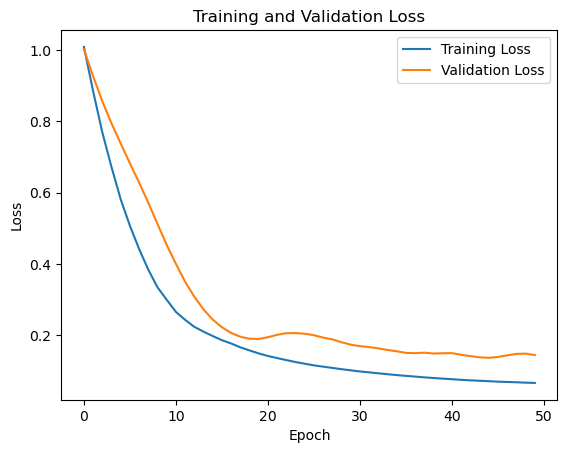

In [348]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Save Model and Test it with y_test

In [349]:
cwd = os.getcwd()
model_path1 = os.path.join(cwd,'saved_model1')
make_dir(model_path1)
model_1.save(os.path.join(model_path1,'NN_model.h5'))
model = load_model(os.path.join(model_path1,'NN_model.h5'))

In [350]:
y_test_pred = model.predict(X_test)

4/4 [==============================] - 0s 2ms/step


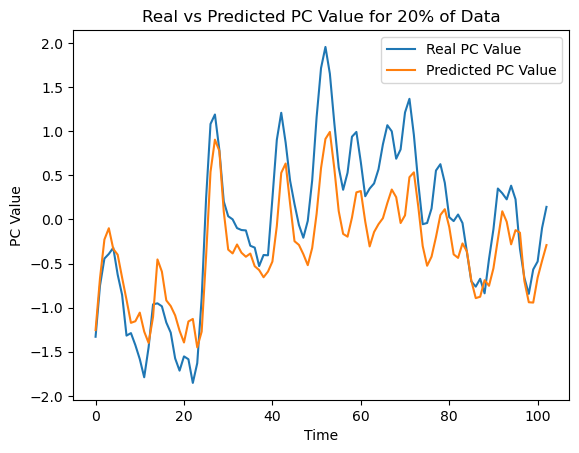

In [351]:
# Plot the training and validation loss
# Not too shabby
plt.plot(y_test, label='Real PC Value')
plt.plot(y_test_pred, label='Predicted PC Value')
plt.title('Real vs Predicted PC Value for 20% of Data')
plt.xlabel('Time')
plt.ylabel('PC Value')
plt.legend()
plt.show()

In [352]:
# Mean Squared Error of 0.148
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.23923821034077786
RMSE: 0.4891198322914108


### Model 2, Recurrent Neural Network

In [447]:
# set hyperparameters
n_neuron       = 32
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 128

In [448]:
model_2 = Sequential()

dropout_rate = 0.2

model_2.add(SimpleRNN(units=n_neuron, input_shape=(5,1)))

model_2.add(Dense(n_neuron,  activation='relu', name="hidden_layer_1"))

model_2.add(Dense(1,  activation='linear', name="output_layer"))


model_2.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [449]:
model_2.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (None, 32)                1088      
                                                                 
 hidden_layer_1 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
_________________________________________________________________


In [450]:
history = model_2.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = None )

Epoch 1/50
3/3 [==============================] - 1s 98ms/step - loss: 0.7249 - val_loss: 1.9555
Epoch 2/50
3/3 [==============================] - 0s 16ms/step - loss: 0.5562 - val_loss: 1.4801
Epoch 3/50
3/3 [==============================] - 0s 16ms/step - loss: 0.4527 - val_loss: 1.1080
Epoch 4/50
3/3 [==============================] - 0s 16ms/step - loss: 0.3791 - val_loss: 0.8306
Epoch 5/50
3/3 [==============================] - 0s 16ms/step - loss: 0.3345 - val_loss: 0.6343
Epoch 6/50
3/3 [==============================] - 0s 16ms/step - loss: 0.3007 - val_loss: 0.5029
Epoch 7/50
3/3 [==============================] - 0s 15ms/step - loss: 0.2689 - val_loss: 0.4203
Epoch 8/50
3/3 [==============================] - 0s 16ms/step - loss: 0.2418 - val_loss: 0.3746
Epoch 9/50
3/3 [==============================] - 0s 15ms/step - loss: 0.2207 - val_loss: 0.3527
Epoch 10/50
3/3 [==============================] - 0s 15ms/step - loss: 0.2070 - val_loss: 0.3337
Epoch 11/50
3/3 [============

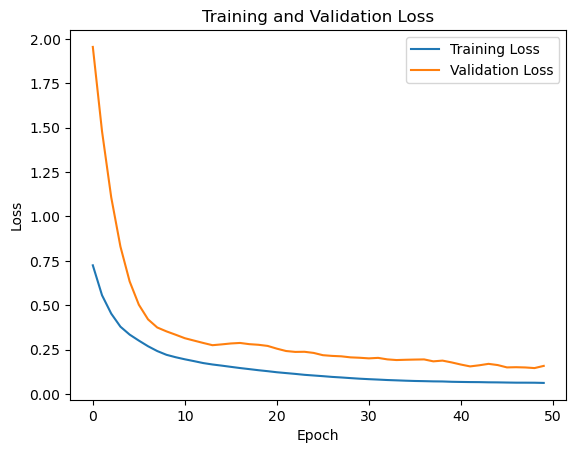

In [451]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [452]:
cwd = os.getcwd()
model_path2 = os.path.join(cwd,'saved_model2')
make_dir(model_path2)
model_2.save(os.path.join(model_path2,'RNN_model.h5'))
model = load_model(os.path.join(model_path2,'RNN_model.h5'))

In [453]:
y_test_pred = model.predict(X_test)

4/4 [==============================] - 0s 2ms/step


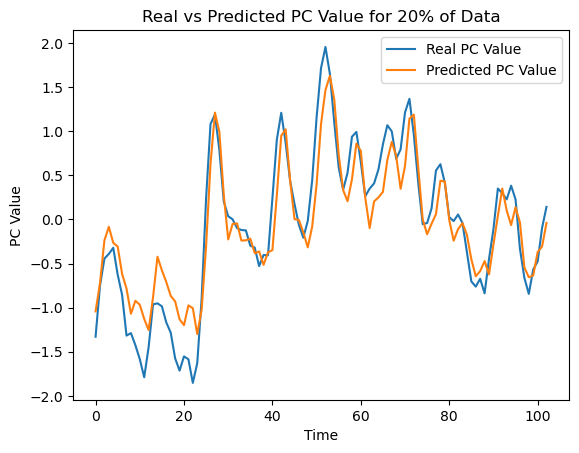

In [454]:
# Plot the training and validation loss
# Not too shabby
plt.plot(y_test, label='Real PC Value')
plt.plot(y_test_pred, label='Predicted PC Value')
plt.title('Real vs Predicted PC Value for 20% of Data')
plt.xlabel('Time')
plt.ylabel('PC Value')
plt.legend()
plt.show()

In [455]:
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.10819875086005079
RMSE: 0.3289357853138676


### Model 3, LSTM Neural Network

In [464]:
# set hyperparameters
n_neuron       = 32
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64

In [465]:
model_3 = Sequential()

dropout_rate = 0.2

model_3.add(LSTM(units=n_neuron, input_shape=(5,1)))

model_3.add(Dense(n_neuron,  activation='relu', name="hidden_layer_1"))
model_3.add(Dense(n_neuron,  activation='relu', name="hidden_layer_2"))

model_3.add(Dense(1,  activation='linear', name="output_layer"))

model_3.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [466]:
model_3.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 32)                4352      
                                                                 
 hidden_layer_1 (Dense)      (None, 32)                1056      
                                                                 
 hidden_layer_2 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 6,497
Trainable params: 6,497
Non-trainable params: 0
_________________________________________________________________


In [467]:
history = model_3.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = None )

Epoch 1/50
6/6 [==============================] - 2s 81ms/step - loss: 0.8200 - val_loss: 1.5662
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.6797 - val_loss: 1.5103
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 0.5655 - val_loss: 1.4534
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4754 - val_loss: 1.4037
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4196 - val_loss: 1.3479
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 0.3989 - val_loss: 1.2610
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 0.3705 - val_loss: 1.1341
Epoch 8/50
6/6 [==============================] - 0s 10ms/step - loss: 0.3404 - val_loss: 1.0160
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 0.3156 - val_loss: 0.8946
Epoch 10/50
6/6 [==============================] - 0s 10ms/step - loss: 0.2913 - val_loss: 0.7883
Epoch 11/50
6/6 [============

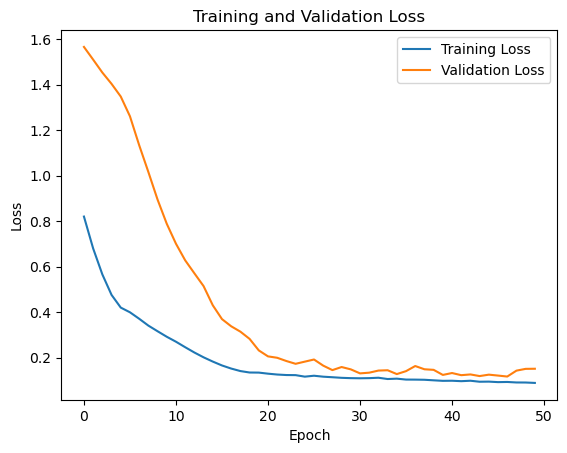

In [468]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [469]:
cwd = os.getcwd()
model_path3 = os.path.join(cwd,'saved_model3')
make_dir(model_path3)
model_3.save(os.path.join(model_path3,'LSTM_model.h5'))
model = load_model(os.path.join(model_path3,'LSTM_model.h5'))

In [470]:
y_test_pred = model.predict(X_test)

4/4 [==============================] - 0s 2ms/step


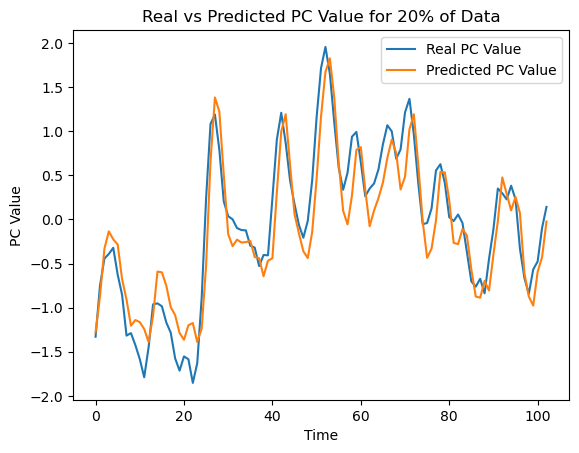

In [471]:
# Plot the training and validation loss
# Not too shabby
plt.plot(y_test, label='Real PC Value')
plt.plot(y_test_pred, label='Predicted PC Value')
plt.title('Real vs Predicted PC Value for 20% of Data')
plt.xlabel('Time')
plt.ylabel('PC Value')
plt.legend()
plt.show()

In [472]:
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.10939508776094224
RMSE: 0.3307492823286881
